In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sy

from scipy.optimize import curve_fit

import pandas as pd  # data parsing library
from matplotlib import cm, colors

from glob import glob

%pylab inline


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
filename = './data/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','alt','H','E'],
                 )  


#df = df.set_index('date')


aproximation coeficients:  [ 0.1179566  0.4023192]


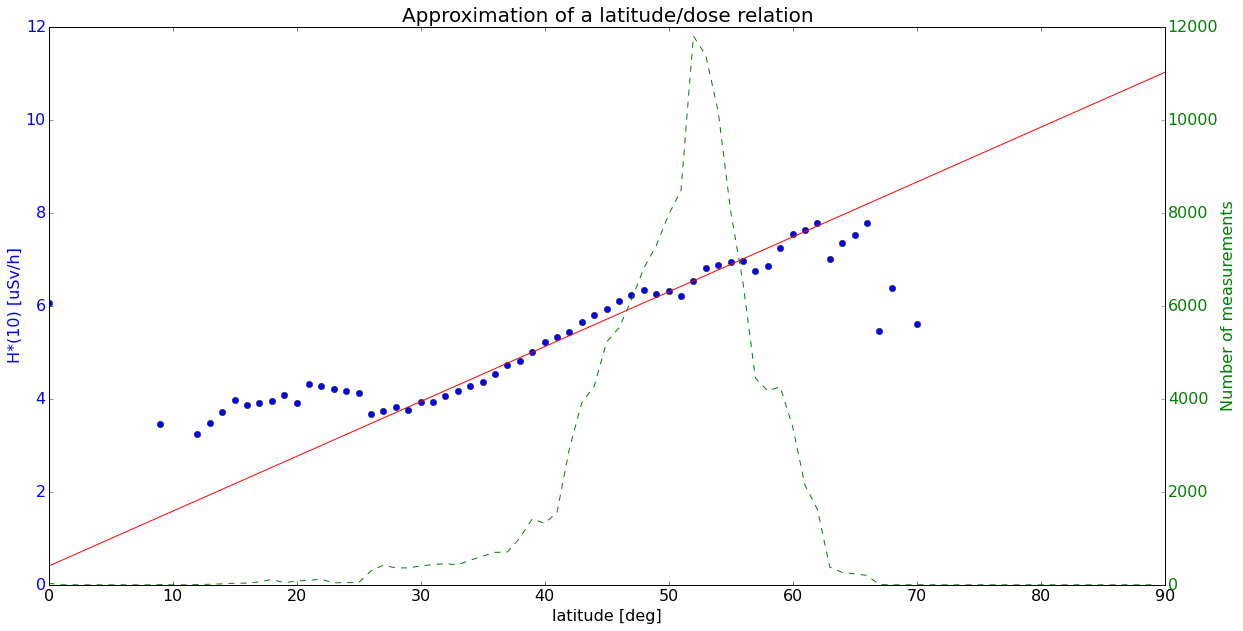

In [5]:
# find latitude relation

plt.figure(figsize=(20, 10))

lat_rad = np.zeros(90)
lat_num = np.zeros(90)


# sum radiation for one degree
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 33000:
            lat_rad[int(round(df['lat'][i]))] += df['H'][i]
            lat_num[int(round(df['lat'][i]))] += 1
            
# average calculation
for i in range(90):
    lat_rad[i] /= lat_num[i]
            
plt.plot(lat_rad[0:90],'o')
    
pf_coef = np.polyfit(range(30,60),lat_rad[range(30,60)],1)     # linear aproximation

print 'aproximation coeficients: ', pf_coef    # aproximation coeficients 

p = (np.poly1d(pf_coef))

plt.plot(sy.linspace(0,90), p(sy.linspace(0,90)), 'r-')
plt.xlabel('latitude [deg]',fontsize=16)
plt.ylabel('H*(10) [uSv/h]', color='blue',fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', colors='blue', labelsize=16)
plt.title('Approximation of a latitude/dose relation', fontsize=20) 
plt.twinx()
plt.plot(lat_num, linestyle='--', color='green')
plt.ylabel('Number of measurements',color='green', fontsize=16)
plt.tick_params(axis='y', colors='green', labelsize=16)


aproximation coeficients:  [ 0.39925592 -8.27386458]


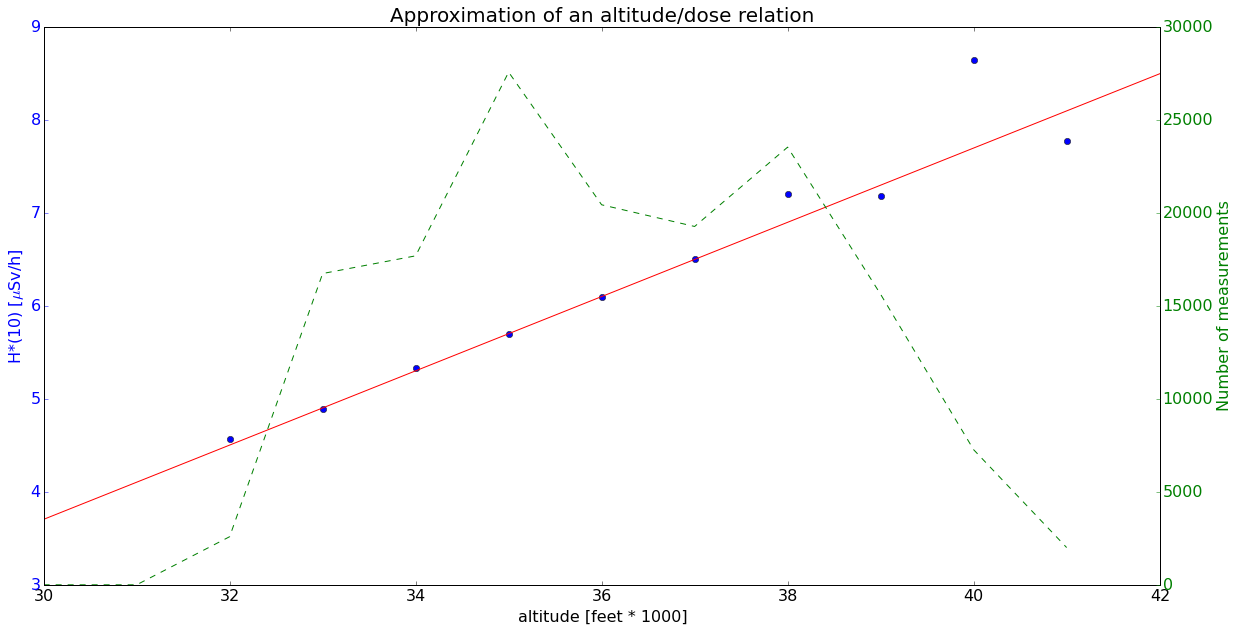

In [6]:
# find altitude relation

plt.figure(figsize=(20, 10))
#%pylab qt
alt_rad = np.zeros(42)
alt_num = np.zeros(42)


# sum radiation for layers per 1000-th feet
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 32000:
            alt_rad[int(round(df['alt'][i] / 1000))] += df['H'][i]
            alt_num[int(round(df['alt'][i] / 1000))] += 1
            
# average calculation
for i in range(len(alt_rad)):
    alt_rad[i] /= alt_num[i]
            
plt.plot(alt_rad,'o')
    
ppf_coef = np.polyfit(range(33,38),alt_rad[range(33,38)],1)       # linear aproximation

print 'aproximation coeficients: ', ppf_coef       # aproximation coeficients

pp = (np.poly1d(ppf_coef))

plt.plot(sy.linspace(30,42), pp(sy.linspace(30,42)), 'r-')
plt.xlabel('altitude [feet * 1000]', fontsize=16)
plt.ylabel('H*(10) [$\mu$Sv/h]', color='blue', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', colors='blue', labelsize=16)
plt.title('Approximation of an altitude/dose relation', fontsize=20) 
plt.twinx()
plt.plot(range(30,42), alt_num[range(30,42)], linestyle='--', color='green')
plt.ylabel('Number of measurements',color='green', fontsize=16)
plt.tick_params(axis='y', colors='green', labelsize=16)

C:\Users\Ondrej\Anaconda\lib\site-packages\IPython\kernel\__main__.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


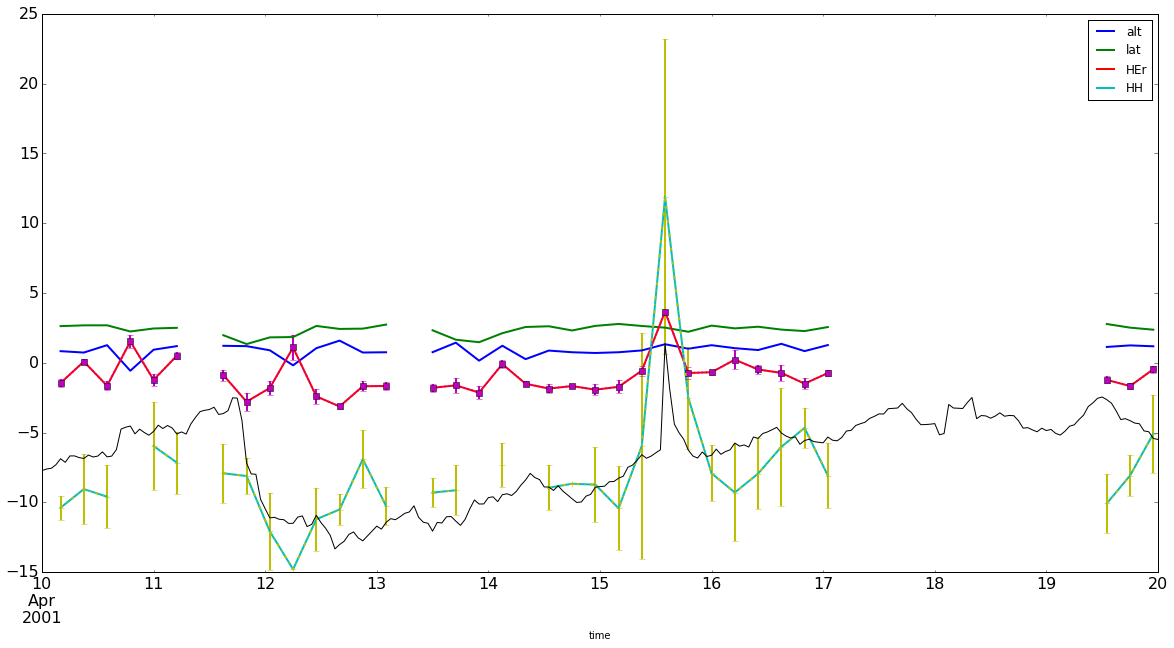

In [11]:
# subtract latitude and altitude relation

aver_period = '5H'

# copy specific columns
df1 = df[['date','H','alt','lat','E']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['H'] - p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'] / 1000)  # subtract altitude relation
df1['HHr'] = df1['HH']/df1['H']  # Relative value of HH for plot
df1['HE'] = df1['H'] - df1['E']  # Difference of H and E
#df1['HEr'] = df1['HE']/df1['E']  # Relative value of HE for plot
df1['HEr'] = df1['HE']/df1['H']  # Relative value of HE for plot
df1.loc[df1.alt <= 32000, 'HH'] = np.NAN   # filtering of low altitudes

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('10Min', how='mean', base=0)
df20 = df2.resample(aver_period, how='mean', base=0)
df20['eHEr'] = df2.HEr.resample(aver_period, how='std', base=0) #calculation of standard deviation of HEr for error bars
df20['eHEr'] = df20['eHEr']*df20['eHEr']
df20['eHH'] = df2.HH.resample(aver_period, how='std', base=0) #calculation of standard deviation of HEr for error bars
df20['eHH'] = df20['eHH']*df20['eHH']

df20.to_csv('./radiation_avg.csv') 

# plot data for given date

FD = '2001-4-15'
#FD = '2001-11-6'
#FD = '2005-12-12'
#FD = '2005-9-18'

df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df20 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df20['date'] = pd.to_datetime(df20['date'])
df20 = df20.set_index('date')
df20['H'] = df20['H'].astype(float)
df20['HE'] = df20['HE'].astype(float) * 5
df20['HH'] = df20['HH'].astype(float) * 5 + 30

df20['HHr'] = df20['HHr'].astype(float)*10 
df20['HEr'] = df20['HEr'].astype(float)*10 

df20['lat'] = df20['lat'] / 20
df20['alt'] = (df20['alt'] - 30000) / 4000

# copy specific columns
#df4 = df2[['alt','lat','HEr', 'HHr']]
df4 = df20[['alt','lat','HEr','HH']]
        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-5))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=5))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
#df2[from_time: to_time].plot(figsize=(20,10),lw='2')
df4[from_time: to_time].plot(figsize=(20,10),lw='2', fontsize=16)
df4['HEr'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':', yerr = df20['eHEr']*5)
df4['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='+',linestyle='-.', yerr = df20['eHH']*2.5)
#plt.errorbar(pd.to_datetime(FD),df4['HEr'],yerr = df20['eHEr'])
#df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
#df2['HE'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='+',linestyle='-.')
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(90)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))

C:\Users\Ondrej\Anaconda\lib\site-packages\IPython\kernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


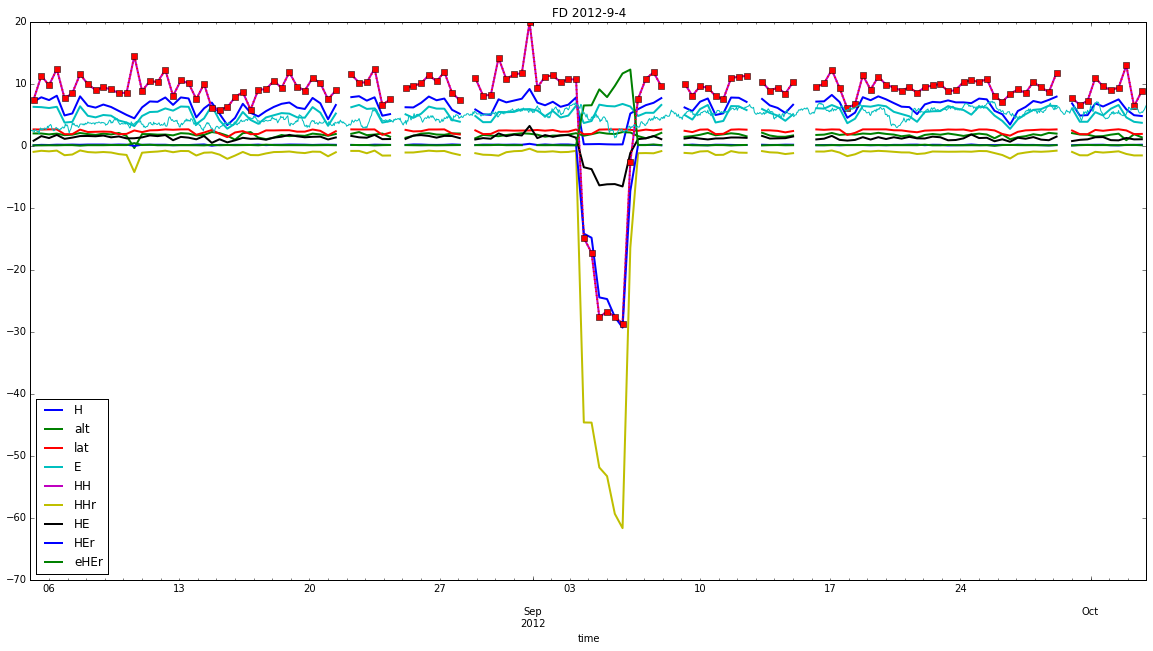

In [28]:
#FD = '2001-5-1'
FD = '2012-9-4'

days_view = 30


df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['H'] = df2['H'].astype(float)
df2['HH'] = df2['HH'].astype(float) * 5 + 40

df2['lat'] = df2['lat'] / 20
df2['alt'] = (df2['alt'] - 30000) / 4000

        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
df2[from_time: to_time].plot(figsize=(20,10),lw='2')
df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(90)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))
plt.title('FD ' + FD)  


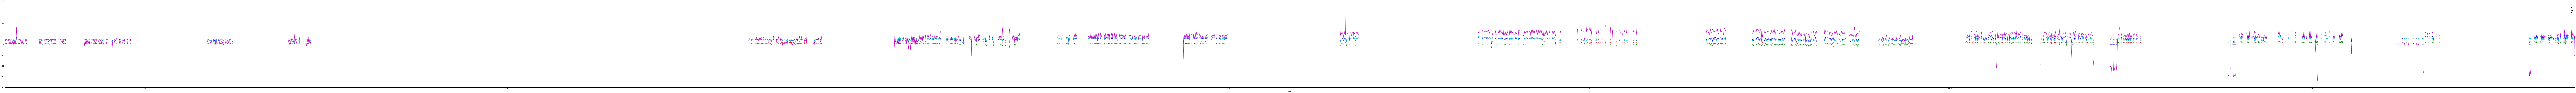

In [34]:
# all data plot

#%pylab qt

df2.plot(figsize=(300, 10))
#df3.plot(figsize=(20, 4))

In [9]:
# MAP

import cartopy.crs as ccrs  # maps plotting library
from cartopy.io.img_tiles import GoogleTiles
#from cartopy.io.img_tiles import OSMx[0:1]
from cartopy.io.srtm import srtm_composite

filename = './data/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','lon','alt','H'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

print filename

plt.figure(figsize=(20, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_extent([-10, +140, 0, +90])
ax.set_extent([-160, +160, -90, +90])
#gg_tiles = GoogleTiles()
#gg_tiles = OSM()
#ax.add_image(gg_tiles, 4)
ax.coastlines()
#df = pd.read_csv(filename,sep=',', header=0 )
#df = df[df['0']>10]


#plt.scatter(lon, lat, marker=(5, 1), color='red', s=200)
#plt.title("date: " + date)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

ax = plt.axes(projection=ccrs.PlateCarree())
#!!!!podkladova mapa ax.stock_img()

df = df.resample('1H', how='mean', base=0)

for i in range(len(df)):
    if df['H'][i] > 0:
        if df['alt'][i] > 32000:
            plt.plot(df['lon'][i], df['lat'][i],
                 color=plt.cm.jet(df['H'][i]/10), 
                 marker='.',
                 transform=ccrs.PlateCarree(), #lw=3
                 )

sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cb = plt.colorbar(sm, shrink=0.7)
cb.set_label('H*(10)[uSy/h]')
plt.show()




ImportError: No module named cartopy.crs

In [11]:
pf_coef[0]

0.1179565960817813